## Define Imports and Determine Device

In [1]:
#!/usr/bin/env python
# coding: utf-8

# ## Define Imports and Determine Device
import os, sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
os.sys.path.insert(0, "source")
from DiabetesData import DiabeticData
from Autoencoder import ConvAutoencoder
from ConvVarAutoencoder import ConvVAE
from DogCatData import DogCatData
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
datatype="diabetes"
batch_size=16
epochs = 2
model_file = ""
normalize=False
size=100

cuda


# read in data

In [3]:
if datatype == "diabetes":
    filename = "data/trainLabels_ad.csv"
    root_dir = "data/diabetes_resized"
    task = ([0],[4])
    # task = ([0,1,2], [3,4])
    # task = ([0,1,2], (3,4))
    classes = ["none", "proliferative"]
    train = pd.read_csv("data/diabetes_ad_train.csv")
    val = pd.read_csv("data/diabetes_ad_valid.csv")
    test = pd.read_csv("data/diabetes_ad_test.csv")

    data = {'train': DiabeticData(df = train, transform_key="train", root_dir=root_dir, task = task, normalize = normalize),
            'valid': DiabeticData(df = val, transform_key="valid", root_dir=root_dir, task = task, normalize = normalize),
            'test': DiabeticData(df = test, transform_key="test", root_dir=root_dir, task = task, normalize = normalize)
            }


elif datatype == "dogcat":
    filename = "data/dogcat_ad.csv"
    root_dir = "data/dogcat/train"
    classes = ['dog', 'cat']
    # task = ([0,1,2], (3,4))

    train = pd.read_csv("data/dogcat_ad_train.csv")
    val = pd.read_csv("data/dogcat_ad_valid.csv")
    test = pd.read_csv("data/dogcat_ad_test.csv")

    data = {'train': DogCatData(df = train, transform_key="train", root_dir=root_dir, normalize = normalize),
            'valid': DogCatData(df = val, transform_key="valid", root_dir=root_dir, normalize = normalize),
            'test': DogCatData(df = test, transform_key="test", root_dir=root_dir, normalize = normalize)
            }

dataloaders = {
        'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
        'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True),
        'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
} 


       Unnamed: 0  Unnamed: 0.1             image  level
0           23248         31705  40036_right.jpeg      0
1            3849          5240    6586_left.jpeg      0
2           10544         14464   18147_left.jpeg      0
3           16706         22819  28799_right.jpeg      0
4           11499         15746   19729_left.jpeg      0
...           ...           ...               ...    ...
23221       18453         25200   31916_left.jpeg      0
23222        9982         13702   17191_left.jpeg      0
23223       24683         33618   42467_left.jpeg      0
23224       10118         13887  17425_right.jpeg      0
23225       24112         32878   41528_left.jpeg      0

[23226 rows x 4 columns]
task = ([0], [4])
      Unnamed: 0  Unnamed: 0.1             image  level
0          21865         29832   37726_left.jpeg      0
1          14013         19225  24247_right.jpeg      0
2          18102         24690   31200_left.jpeg      0
3          13011         17851  22488_right.jpeg

In [4]:
model = ConvAutoencoder(device, datatype)
print(model)
if model_file != "":
    model.load_state_dict(torch.load(model_file))

model.fit(epochs, dataloaders["train"], dataloaders["valid"])


  0%|          | 0/1452 [00:00<?, ?it/s]

ConvAutoencoder(
  (encoder_layers): ModuleList(
    (0): Conv2d(3, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(1024, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder_layers): ModuleList(
    (0): ConvTranspose2d(4, 1024, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(1024, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
  (criterion): BCELoss()
)
in fit function
Epoch: 1


100%|██████████| 1452/1452 [04:48<00:00,  5.03it/s]


Epoch: 1 	Training Loss: 7.906760


  0%|          | 0/1452 [00:00<?, ?it/s]

Epoch: 2


100%|██████████| 1452/1452 [04:48<00:00,  5.04it/s]


Epoch: 2 	Training Loss: 7.830068


<Figure size 432x288 with 0 Axes>

/home/tntech.edu/kebrown46/miniconda3/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/tntech.edu/kebrown46/miniconda3/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


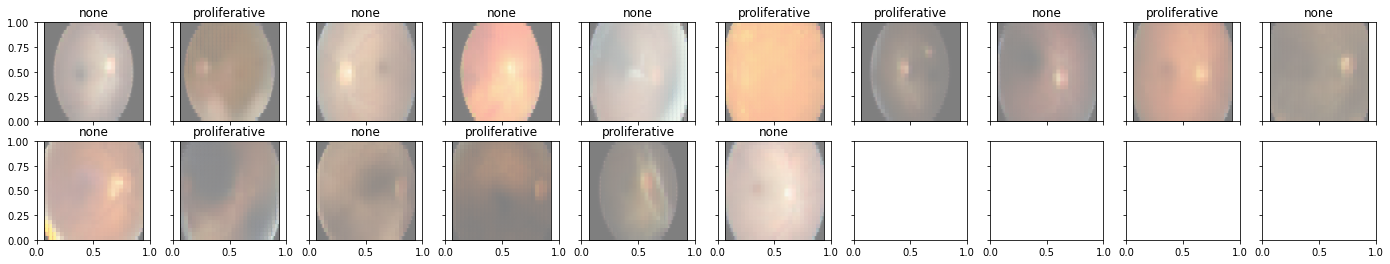

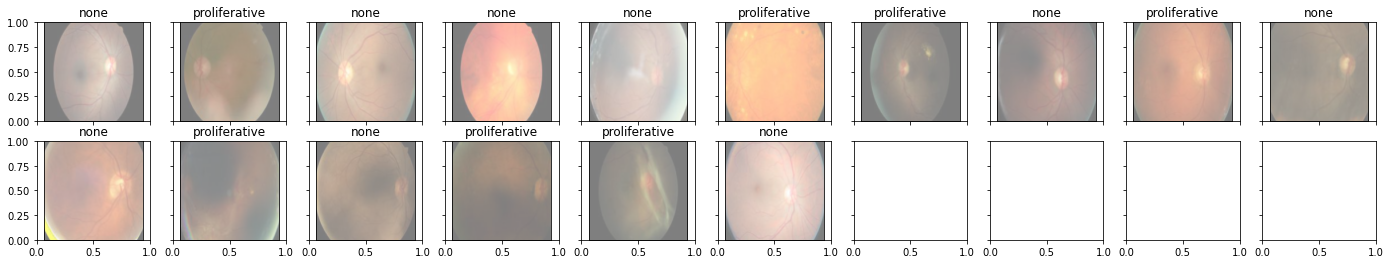

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))


# obtain one batch of test images
dataiter = iter(dataloaders["test"])
images, labels = dataiter.next()
images, labels = dataiter.next()

# get sample outputs
output = model(images.to(device))
# output = F.softmax(output)
# prep images for display
images = images.numpy()


# output is resized into a batch of iages
output = output.view(batch_size, 3, size, size)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# # plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))

# # input images on top row, reconstructions on bottom
# for images, row in zip([images, output], axes):
#     for img, ax in zip(images, row):
#         ax.imshow(np.squeeze(img))
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])


# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


Now, we loop through the training set and calculate reconstruction loss 

In [6]:
dataloaders['valid'] = DataLoader(data['valid'], batch_size=1, shuffle=True)
dataloaders['test'] = DataLoader(data['test'], batch_size=1, shuffle=True)

results = []
results_cols = ["Image Label", "Reconstruction Loss"]
for x, y in dataloaders['valid']:
    X = x.to(device)
    output = model(X)
    output = output.cpu().detach().numpy()
    for i in range(y.shape[0]):
        ls = 0
        image = x[i].numpy()
        ouptut = output[i]
        label = y[i].numpy()
        ls = np.sum(np.square(image.ravel() - output.ravel()))
        # ls = model.criterion(output, image)
        results.append([label, ls])

results = pd.DataFrame(results, columns=results_cols)
results.to_csv("reconstruction_error.csv")


#find error threshold on validation set



#evaluate on testing data

     Image Label  Reconstruction Loss
0              0            13.650553
1              1            24.095779
2              1            13.847072
3              0            18.479595
4              0            17.599632
...          ...                  ...
1641           1            10.023101
1642           0             9.980496
1643           0            22.890989
1644           0            14.601444
1645           0            10.756351

[1646 rows x 2 columns]
     Image Label  Reconstruction Loss
0              0            13.650553
3              0            18.479595
4              0            17.599632
5              0            40.478245
7              0            28.247837
...          ...                  ...
1640           0            13.323956
1642           0             9.980496
1643           0            22.890989
1644           0            14.601444
1645           0            10.756351

[1305 rows x 2 columns]
     Image Label  Reconstruction Loss


Text(0, 0.5, 'Frequency')

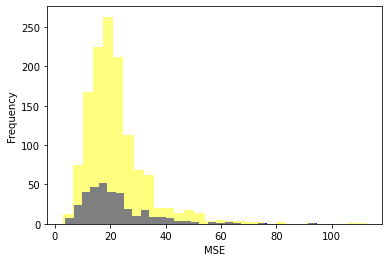

In [7]:
print(results)
label_1 = results[results["Image Label"] == 1]
label_0 = results[results["Image Label"] == 0]
print(label_0)
print(label_1)
avg_1 = np.mean(label_1['Reconstruction Loss'].values)
avg_0 = np.mean(label_0['Reconstruction Loss'].values)

print("Average Reconstruction Error (Prediction = 0)", avg_0)
print("Average Reconstruction Error (Prediction = 1)", avg_1)

plt.hist(label_1['Reconstruction Loss'].values, density=False, bins=30, color='blue')
plt.hist(label_0['Reconstruction Loss'].values, density=False, bins=30, alpha = 0.5,color='yellow')
plt.xlabel('MSE')
plt.ylabel('Frequency')


In [8]:
threshold = 25
y_true = []
y_pred = []
for x, y in dataloaders['test']:
    X = x.to(device)
    output = model(X)
    output = output.cpu().detach().numpy()
    for i in range(y.shape[0]):
        ls = 0
        image = x[i].numpy()
        ouptut = output[i]
        label = y[i].numpy()
        ls = np.sum(np.square(image.ravel() - output.ravel()))
        print(ls)
        y_true.append(label)
        if ls >= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)

print(y_true)
print(y_pred)

15.195786
24.429089
21.33163
16.952635
27.096115
19.98292
20.50819
18.522928
14.586868
20.822027
20.904755
12.591202
36.14334
28.844597
3.0102115
15.9575615
7.6190567
25.48405
21.138802
17.375063
31.443758
42.804913
11.304302
13.294804
20.473186
25.583296
11.950188
36.56405
39.477406
5.196267
14.473588
18.021656
23.308226
47.117813
17.22793
14.857914
28.19395
16.365543
39.77863
20.404507
20.182146
18.84069
26.55197
10.958954
17.387217
12.385526
12.234747
17.054693
20.13679
27.474052
18.604883
65.71147
9.366926
22.428123
27.515162
32.4627
29.19314
17.458649
18.290806
12.271838
23.552198
50.60177
36.641094
38.026894
33.39165
13.7724695
23.842571
53.633003
18.787464
42.66756
18.689129
28.04161
19.218748
19.63512
18.521446
14.839589
36.7223
14.149271
26.986942
24.632479
20.311115
17.468342
24.638817
63.23875
25.71144
23.810719
7.5497756
18.81573
74.14445
16.117495
24.399136
28.19301
20.717728
20.352114
17.132093
13.268069
17.17801
31.976936
16.08242
10.558954
17.636904
22.70557
22.497166
8

17.03985
15.588699
24.472643
13.761321
14.57341
14.994459
28.47012
45.293922
15.042836
10.996776
6.837303
36.157944
15.05137
13.261795
18.416697
12.752508
41.207577
36.597164
18.254591
15.488609
26.51772
18.28351
22.603153
20.01051
14.5333395
17.304377
21.621426
27.635273
21.06787
33.387436
13.304199
16.31892
38.1329
20.376856
18.984236
18.72627
33.938915
20.429064
11.346775
22.154062
7.6876717
22.582104
32.943058
17.212479
10.370136
16.202137
13.27827
14.956968
20.323053
15.583856
11.913616
12.874487
24.699928
26.089432
15.216707
24.503906
8.981692
22.397568
11.930621
18.28984
22.434362
19.169306
17.335056
23.057323
17.028008
11.714545
11.770509
6.743403
14.634265
16.562548
14.430323
43.740017
75.073875
10.275894
14.0192375
19.719055
16.25507
19.828846
23.836742
13.615107
8.221546
27.885874
18.71065
17.322792
19.55468
22.182837
28.124208
23.14446
17.743542
70.70915
14.948154
18.418901
23.19501
12.157468
19.532354
18.78205
25.90651
10.047878
17.921482
14.234905
14.649276
22.345207
14.3

In [9]:
accuracy = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Accuracy: ", accuracy)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1-Score: ", f1)
print("Confusion Matrix: ", cm)

Accuracy:  0.6160388821385177
Precision:  0.19817767653758542
Recall:  0.23705722070844687
F1-Score:  0.21588089330024815
Confusion Matrix:  [[927 352]
 [280  87]]
